# Metis Data Science Bootcamp
## San Francisco, Winter 2020
### Project 4: Election Reporting Sentiment Analysis

In [1]:
import sys
import re
import os.path
import requests
import time
import pandas as pd

from os import path

from pymongo import MongoClient

In [2]:
from sklearn.feature_extraction.text import CountVectorizer 
from sklearn.decomposition import TruncatedSVD
from sklearn.decomposition import NMF
from sklearn.metrics.pairwise import cosine_similarity

In [3]:
db_client = MongoClient()
db_news = db_client['news_search']
db_news_col = db_news['search_result']

In [4]:
db_news_content = db_news['news_content']
cursor = db_news_content.find({}, {'_id':0, 'name': 1, 'text': 1, 'url' : 1, 'base_url' : 1, 'pub_date': 1})

In [5]:
char_count = 0;

for article in list(cursor) :
    for block in article['text'] :
        char_count += len(block)
        
print(char_count)

14682206


In [6]:
cursor = db_news_content.find({}, {'_id':0, 'name': 1, 'text': 1, 'url' : 1, 'base_url' : 1, 'pub_date': 1})
print(len(list(cursor)))

3088


In [7]:
import re
import string

alphanumeric = lambda x: re.sub('\w*\d\w*', ' ', x)
punc_lower = lambda x: re.sub('[%s]' % re.escape(string.punctuation+'\\'), ' ', x.lower())



In [8]:
db_news_content = db_news['news_content']

cursor = db_news_content.find({}, {'_id':0, 'name': 1, 'text': 1, 'url' : 1, 'base_url' : 1, 'pub_date': 1})
article_count = 0
total_words = 0

for article in list(cursor):
    word_list = []
    article_count += 1
    clean_text = ''
    clean_text = punc_lower(alphanumeric(article['text']))
    clean_text = re.sub('\w*\d\w*', ' ', clean_text)
    clean_text = article['text']
    word_list = clean_text.split()
    # print(article['name'], len(word_list))
    total_words += len(word_list)
    
print(article_count, total_words)

3088 2322793


In [9]:
#db_news.news_search.update_many({}, { '$set' : { "scraped": 'y'}})

In [10]:
# First let's clean the text
cursor = db_news_content.find({}, {'_id':1, 'name': 1, 'text': 1, 'url' : 1, 'base_url' : 1, 'pub_date': 1})
db_news_sentences = db_news['sentences']
for article in list(cursor) :
    # make alphanumeric and lower case
    clean_text = punc_lower(alphanumeric(article['text']))
    
    # remove numbers
    clean_text = re.sub('\w*\d\w*', ' ', clean_text)
    
    # remove punctuation
    clean_text = re.sub('[%s]' % re.escape(string.punctuation), ' ', clean_text)
    clean_text = re.sub('\\xa0', ' ', clean_text)
    
    # word_list = clean_text.split()
    word_list = [ x for x in word_list if (len(x) >= 2) ]
    db_news_content.update_one({ '_id': article['_id']}, { '$set' : { 'clean_text' : clean_text }})
    db_news_content.update_one({ '_id': article['_id']}, { '$set' : { 'word_list' : word_list }})

In [11]:
cursor = db_news_content.find({}, {'_id':1, 'word_list' : 1 })
article = list(cursor)[0]


['This',
 'material',
 'may',
 'not',
 'be',
 'published,',
 'broadcast,',
 'rewritten,',
 'or',
 'redistributed.',
 '©2020',
 'FOX',
 'News',
 'Network,',
 'LLC.',
 'All',
 'rights',
 'reserved.',
 'All',
 'market',
 'data',
 'delayed',
 '20',
 'minutes.',
 'Former',
 'Obama',
 'National',
 'Finance',
 'Committee',
 'member',
 'Don',
 'Peebles',
 'says',
 '2020',
 'hopeful',
 'Sen.',
 'Elizabeth',
 "Warren's",
 'aggressive',
 'wealth',
 'tax',
 'plan',
 'will',
 'strangle',
 'the',
 'economy.Massachusetts',
 'Sen.',
 'Elizabeth',
 'Warren',
 'has',
 'rallied',
 'progressive',
 'voters',
 'in',
 'what',
 'has',
 'proven',
 'to',
 'be',
 'formidable',
 'effort',
 'to',
 'become',
 'the',
 'second',
 'consecutive',
 'woman',
 'to',
 'secure',
 'the',
 'Democratic',
 'nomination',
 'for',
 'president.',
 'Following',
 '30-year',
 'career',
 'as',
 'law',
 'professor,',
 'she',
 'unseated',
 'moderate',
 'Republican',
 'Sen.',
 'Scott',
 'Brown',
 'in',
 '2012',
 'before',
 'winning',
 're

## Named Entitity Identification

In [53]:
import spacy
from spacy import displacy
from pprint import pprint
from collections import Counter
import en_core_web_sm
nlp = en_core_web_sm.load()

In [60]:
from spacy.lang.en import English
nlp = English()
# Create a Tokenizer with the default settings for English
# including punctuation rules and exceptions
sentencizer = nlp.create_pipe("sentencizer")
nlp.add_pipe(sentencizer)

tokenizer = nlp.Defaults.create_tokenizer(nlp)from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer

# Create a SentimentIntensityAnalyzer object. 
sid_obj = SentimentIntensityAnalyzer()

        
cursor = db_news_sentences.find({}, {'_id':1, 'text': 1, 'parent_id':1})
sentence = list(cursor)[0]

sentiment_dict = sid_obj.polarity_scores(sentence['text'])
sentiment_dict


In [77]:
# First let's clean the text
cursor = db_news_content.find({}, {'_id':1, 'name': 1, 'text': 1, 'url' : 1, 'base_url' : 1, 'pub_date': 1})
db_news_sentences = db_news['sentences']
for article in list(cursor) :
    # make alphanumeric and lower case
    # clean_text = punc_lower(alphanumeric(article['text']))
    
    # remove numbers
    #clean_text = re.sub('\w*\d\w*', ' ', clean_text)
    clean_text = re.sub('\\xa0', ' ', article['text'])
    
    doc = nlp(clean_text)
    
    for sent in doc.sents:
        sentiment_dict = sid_obj.polarity_scores(sentence['text'])
        db_news_sentences.insert_one({'parent_id': article['_id'], 'text' : sent.text, 'sentiment': sentiment_dict})

In [84]:
score_list = []        
cursor = db_news_sentences.find({}, {'_id':1, 'text': 1, 'parent_id':1, 'sentiment':1})
for sentence in list(cursor) :
    score_list.append(sentence['sentiment']['compound'])
    
db_news_sentences.count_documents({})

81682

(array([ 216.,   43.,   31.,   28.,   18.,  138.,   49.,   69.,   96.,
        1517.]),
 array([-0.9999 , -0.79992, -0.59994, -0.39996, -0.19998,  0.     ,
         0.19998,  0.39996,  0.59994,  0.79992,  0.9999 ]),
 <a list of 10 Patch objects>)

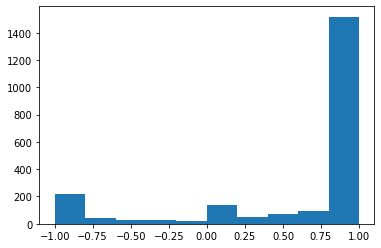

In [91]:
import matplotlib.pyplot as plt

plt.hist(score_list)

In [86]:
max(score_list)

0.0

In [89]:
cursor = db_news_content.find({}, {'_id':1, 'name': 1, 'text': 1, 'url' : 1, 'base_url' : 1, 'pub_date': 1})
score_list = []
for article in list(cursor) :
    score_list.append(sid_obj.polarity_scores(article['text'])['compound'])

In [90]:
max(score_list)

0.9999

In [76]:
# db_news.drop_collection('sentences')

{'nIndexesWas': 1, 'ns': 'news_search.sentences', 'ok': 1.0}

In [51]:
cursor = db_news_content.find({}, {'_id':1, 'clean_text' : 1 })
article = list(cursor)[0]

text = tokenizer(article['clean_text'])
# Tag the parts of speech
doc = nlp(text.text)

# tokenize the text
word_list = [token.text for token in doc if not token.is_stop]
word_list = [token for token in word_list if token.isalpha() and (len(token) >= 2)]
word_list

['washington',
 'bernie',
 'sanders',
 'said',
 'tuesday',
 'night',
 'planning',
 'release',
 'additional',
 'medical',
 'records',
 'sanders',
 'suffered',
 'heart',
 'attack',
 'october',
 'campaign',
 'event',
 'blockage',
 'artery',
 'stents',
 'inserted',
 'campaign',
 'said',
 'time',
 'speaking',
 'cnn',
 'town',
 'hall',
 'las',
 'vegas',
 'sanders',
 'asked',
 'clarify',
 'presidential',
 'campaign',
 'releasing',
 'medical',
 'records',
 'previously',
 'stated',
 'sanders',
 'democractic',
 'candidate',
 'debate',
 'wedneday',
 'night',
 'warren',
 'rips',
 'bloomberg',
 'egomaniac',
 'billionaire',
 'dems',
 'prepare',
 'new',
 'rival',
 'debate',
 'stageat',
 'time',
 'said',
 'people',
 'right',
 'know',
 'health',
 'senator',
 'somebody',
 'running',
 'president',
 'united',
 'states',
 'disclosure',
 'tuesday',
 'said',
 'released',
 'documentation',
 'candidate',
 'reiterated',
 'letters',
 'cardiologists',
 'doctors',
 'said',
 'good',
 'health',
 'think',
 'released'

In [75]:
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer

# Create a SentimentIntensityAnalyzer object. 
sid_obj = SentimentIntensityAnalyzer()

        
cursor = db_news_sentences.find({}, {'_id':1, 'text': 1, 'parent_id':1})
sentence = list(cursor)[0]

sentiment_dict = sid_obj.polarity_scores(sentence['text'])
sentiment_dict

{'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound': 0.0}

In [15]:
pprint([(X.text, X.label_) for X in doc.ents])

[]


In [29]:
js = doc.to_json()
pprint(js)

{'ents': [{'end': 10, 'label': 'GPE', 'start': 0},
          {'end': 27, 'label': 'PERSON', 'start': 13},
          {'end': 40, 'label': 'DATE', 'start': 33},
          {'end': 46, 'label': 'TIME', 'start': 41},
          {'end': 125, 'label': 'DATE', 'start': 123},
          {'end': 161, 'label': 'DATE', 'start': 154},
          {'end': 211, 'label': 'CARDINAL', 'start': 208},
          {'end': 226, 'label': 'CARDINAL', 'start': 223},
          {'end': 298, 'label': 'ORG', 'start': 295},
          {'end': 323, 'label': 'GPE', 'start': 314},
          {'end': 332, 'label': 'ORG', 'start': 325},
          {'end': 510, 'label': 'LOC', 'start': 499},
          {'end': 542, 'label': 'TIME', 'start': 528},
          {'end': 555, 'label': 'PERSON', 'start': 549},
          {'end': 570, 'label': 'PERSON', 'start': 561},
          {'end': 605, 'label': 'NORP', 'start': 601},
          {'end': 645, 'label': 'CARDINAL', 'start': 638},
          {'end': 789, 'label': 'GPE', 'start': 772},
       

## Sentiment Analysis

In [15]:
from nltk.corpus import stopwords

# import SentimentIntensityAnalyzer class 
# from vaderSentiment.vaderSentiment module. 
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer

# Create a SentimentIntensityAnalyzer object. 
sid_obj = SentimentIntensityAnalyzer()



cursor = db_news_content.find({}, {'_id':1, 'word_list' : 1 })
article = list(cursor)[0]
word_list = article['word_list']

filtered_words = [word for word in word_list if word not in stopwords.words('english')]

filtered_sentence = f' '.join(filtered_words)


sentiment_dict = sid_obj.polarity_scores(filtered_sentence)
sentiment_dict

{'neg': 0.061, 'neu': 0.881, 'pos': 0.058, 'compound': -0.1027}

In [76]:
cursor = db_news_content.find({}, {'_id':1, 'word_list' : 1 })
bag_of_words = []
for article in list(cursor) :
    bag_of_words.extend(article['word_list'])
    
len(bag_of_words)

1462551

In [49]:
vectorizer = CountVectorizer(stop_words='english')
doc_word = vectorizer.fit_transform(bag_of_words)
doc_word.shape

(1462551, 30456)

## Topic Modeling below

In [63]:
lsa = TruncatedSVD(10)
doc_topic = lsa.fit_transform(doc_word)
lsa.explained_variance_ratio_

array([0.01052819, 0.00981248, 0.00868021, 0.00862759, 0.00844439,
       0.00776041, 0.00769827, 0.0070162 , 0.00657115, 0.00628442])

In [64]:
def display_topics(model, feature_names, no_top_words, topic_names=None):
    for ix, topic in enumerate(model.components_):
        if not topic_names or not topic_names[ix]:
            print("\nTopic ", ix)
        else:
            print("\nTopic: '",topic_names[ix],"'")
        print(", ".join([feature_names[i]
                        for i in topic.argsort()[:-no_top_words - 1:-1]]))

In [65]:
display_topics(lsa, vectorizer.get_feature_names(), 5)


Topic  0
said, party, voters, klobuchar, primary

Topic  1
sanders, party, bloomberg, bernie, klobuchar

Topic  2
iowa, support, voters, candidates, people

Topic  3
campaign, iowa, support, candidates, mayor

Topic  4
biden, support, voters, candidates, iowa

Topic  5
democratic, support, voters, party, bernie

Topic  6
new, party, klobuchar, primary, hampshire

Topic  7
warren, hampshire, presidential, candidate, caucus

Topic  8
bloomberg, bernie, hampshire, party, mayor

Topic  9
trump, presidential, hampshire, tuesday, president


In [66]:
import spacy

cursor = db_news_content.find({}, {'_id':1, 'text' : 1 })

article = list(cursor)[1]

nlp = spacy.load("en_core_web_sm")
doc = nlp(article['text'])

# document level
ents = [(e.text, e.label_, e.kb_id_) for e in doc.ents]
print(ents)  # [('Ada Lovelace', 'PERSON', 'Q7259'), ('London', 'GPE', 'Q84')]

# token level
ent_ada_0 = [doc[0].text, doc[0].ent_type_, doc[0].ent_kb_id_]
ent_ada_1 = [doc[1].text, doc[1].ent_type_, doc[1].ent_kb_id_]
ent_london_5 = [doc[2].text, doc[2].ent_type_, doc[2].ent_kb_id_]
print(ent_ada_0)  # ['Ada', 'PERSON', 'Q7259']
print(ent_ada_1)  # ['Lovelace', 'PERSON', 'Q7259']
print(ent_london_5)  # ['London', 'GPE', 'Q84']

[('Bernie Sanders', 'PERSON', ''), ('D-VT', 'ORG', ''), ('2020', 'CARDINAL', ''), ('Democratic', 'NORP', ''), ('last year', 'DATE', ''), ('2020', 'DATE', ''), ('CNN', 'ORG', ''), ('Town Hall', 'FAC', ''), ('three', 'CARDINAL', ''), ('three', 'CARDINAL', ''), ('four', 'CARDINAL', ''), ('October 2019', 'DATE', ''), ('Las Vegas', 'GPE', ''), ('two days', 'DATE', ''), ('about two weeks', 'DATE', '')]
['Press', '', '']
['Play', '', '']
[',', '', '']
